# How to Master The Subtle Art of Train And Test Set Generation
## There is more to it than vanilla `train_test_split` function
<img src='images/jump.jpg'></img>
<figcaption style="text-align: center;">
    <strong>
        Photo by 
        <a href='https://www.pexels.com/@mary-taylor?utm_content=attributionCopyText&utm_medium=referral&utm_source=pexels'>Mary Taylor</a>
        on 
        <a href='https://www.pexels.com/photo/active-man-jumping-from-brick-wall-6009265/?utm_content=attributionCopyText&utm_medium=referral&utm_source=pexels'>Pexels</a>
    </strong>
</figcaption>

### Setup

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

### Introduction

Arguably, the first function you learned from Scikit-learn is `train_test_split`. It performs the most basic yet a crucial task: diving the data into train and test sets. You fit the relevant model to the training set and test its accuracy on the test set. Sounds simple. But let me tell you, it is not simple. Not simple at all.

Scikit-learn provides a whopping amount of [15 different functions](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) to split your data depending on different use-cases. Some of them you never heard of, some of them are used daily. But don't worry, we won't cover all of them here. Instead, we will only focus on the most common and important ones used by scientists ranging from beginner to Kaggle Grandmasters. Specifically, you will learn the most important parameter of `train_test_split` for classification tasks, in other words - stratifying and how to perform cross-validation using `cross_validate`, `cross_val_score` and `StratifiedKFold`.

### Still need a clarification for `train_test_split`?

For complete starters, let me elaborate on the `train_test_split`. Suppose we want to predict the price of a diamond depending on its several attributes like carat and the length of its dimensions. As sample data, we will load the `diamonds` dataset from Seaborn:

In [2]:
diamonds = sns.load_dataset('diamonds')
diamonds

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53936,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53937,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53938,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


The dataset has several numerical and three categorical features. Since we want to predict continuous values, we can choose any regression algorithm, like `RandomForestRegressor` for the task.

For all ML algorithms, there is a single, clearly defined process: divide the data into training and testing sets, fit the model on the training set and test accuracy on the test set. The reason models are not trained on all of the data is that we mostly care about how a model performs on unseen data. And almost always, you won't have enough brand-new, real-world data to test. So, the only option is to put aside some of the available data for testing. Read more about training and testing process [here](https://towardsdatascience.com/codeless-machine-learning-dictionary-for-dummies-fa912cc7bdfe).

The splitting task can be done using Scikit-learn's `train_test_split` function. Below, we choose the variables to be used to predict the diamond prices as features (*X* array) and the prices itself as the target (*y* array):

In [3]:
from sklearn.model_selection import train_test_split

# Create features and target arrays
X = diamonds[['carat', 'table', 'depth']]
y = diamonds.price

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=1121218)

The function is imported from `sklearn.model_selection`. For the first 2 arguments, we pass the feature array first and then, target array. The size of the test set is specified with `test_size` argument - here we are setting aside 30% of the data for testing. `random_state` is seeded so we get consistent results every time we run the function with the same arguments.

We unpack the output into 4 variables. I want you to note the order of the outputs because it is easy to mix them.

Next, we will fit a `RandomForestRegressor` model with default parameters and score it:

In [4]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the model
forest = RandomForestRegressor()

# Fit to the training
forest.fit(X_train, y_train)

# Print the training score
print("The coefficient of determination for the training set:", forest.score(X_train, y_train))
print("The coefficient of determination for the test set:", forest.score(X_test, y_test))

The coefficient of determination for the training set: 0.9595144061049018
The coefficient of determination for the test set: 0.868845446494166


That's is the basic usage of `train_test_split` for regression. But things will get more interesting if we include categoricals into the mix.

### Sampling Bias
Before I explain how to use `train_test_split` for categorical features, I have to briefly mention *sampling bias*. Sampling bias occurs when the chosen sample is not representative of the population. For example, an ice-cream company may call 1000 people to find out what ice-cream flavors they like. Not to create a sampling bias, or in other words, to choose a representative ratio, the surveyors should respect the ration of males and females in the given area or city. If there are 54% males and 46% females in the area, the company has to make sure to survey 540 men and 460 women to get a representative sample. 

When we split the data into training and test sets, we are essentially taking samples from the population. So, whenever there are categorical variables involved, we should split the data in a way that keeps the underlying proportion of categories the same or close to same.

Formally, this type of sampling is called *stratified sampling* and each unique category is called a *strata*. Next, we will see how can use this method in code.

### Stratified Splits With `train_test_split`

Stratified sampling is super easy in Scikit-learn, just add `stratify=feature_name` parameter to the function. To prove this works, let's split diamonds dataset both with vanilla splits and stratification. 

In [5]:
# Build feature and target
X = diamonds.select_dtypes(include='category')
y = diamonds.price

# Vanilla split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=1121218)

This time, we are only using the categorical variables. Let's see the proportion of categories in both `X` and `X_train`:

In [6]:
X['clarity'].value_counts(normalize=True)

SI1     0.242214
VS2     0.227253
SI2     0.170449
VS1     0.151483
VVS2    0.093919
VVS1    0.067760
IF      0.033185
I1      0.013737
Name: clarity, dtype: float64

In [7]:
X_train['clarity'].value_counts(normalize=True)

SI1     0.242915
VS2     0.227846
SI2     0.171513
VS1     0.150246
VVS2    0.093358
VVS1    0.067456
IF      0.033053
I1      0.013613
Name: clarity, dtype: float64

You would think that the differences in proportions are not that great. But even the tiniest fractional change can throw off a model when it comes to predictions. Here is a clear example of this:

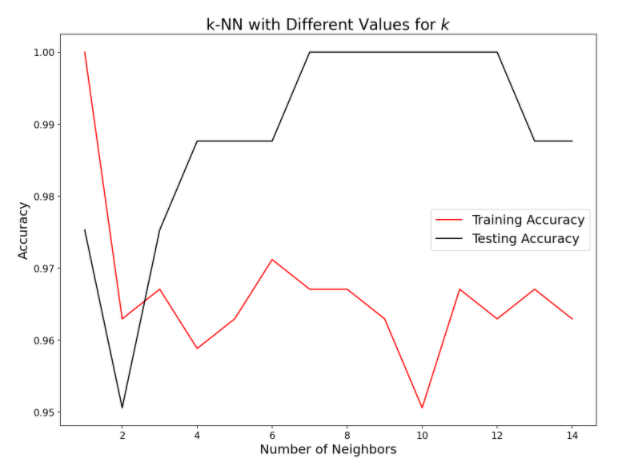

Above is a model complexity curve of a kNN classifier that was trained and tested on a vanilla split. As you can see, almost all testing scores are higher than training. Here is the result after the model was retrained on a stratified split:

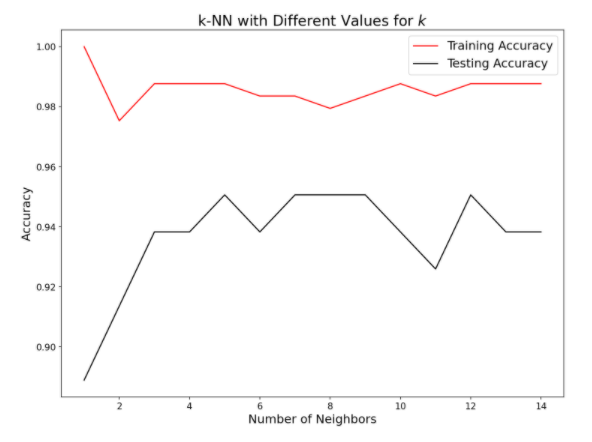

You can see how vastly stratification changes the performance of a model. 

> Generally, when you see a testing score higher than training, don't be overexcited that you built something exceptional. It is the exact opposite, somewhere along the way you made a blunder😁🤦‍♂️. 

Here is how you can split the data by stratifying on the diamond's cut:

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, stratify=X['cut'], random_state=1121218)

In [9]:
X['cut'].value_counts(normalize=True)

Ideal        0.399537
Premium      0.255673
Very Good    0.223990
Good         0.090953
Fair         0.029848
Name: cut, dtype: float64

In [10]:
X_train['cut'].value_counts(normalize=True)

Ideal        0.399544
Premium      0.255681
Very Good    0.223979
Good         0.090948
Fair         0.029848
Name: cut, dtype: float64

Setting the `stratify` to a categorical feature (or the target if you are doing classification, i. e. `stratify=y`) ensures that split is done to preserve the proportion of categories in the passed column. As you can see, the proportions are preserve to 4th decimal place.

### Cross-validation with `cross_val_score`

Regardless of how you tweak `train_test_split` to get a perfect split, there is a chance that the sets turn out to be biased. For example, among the infinitely many variations of train/test sets, you can end up with a wildly unbalanced set of cheap and expensive diamond features. It is rare but could happen resulting in a completely useless model. This situation becomes even less rare for smaller datasets.

One way to deal with this is to use a technique called k-fold cross validation:

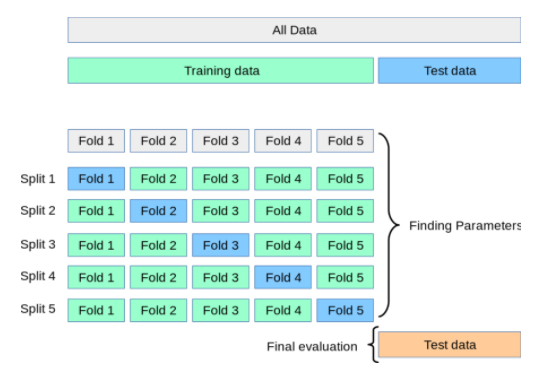
<figcaption style="text-align: center;">
    <strong>
        <a href='https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation'>From Scikit-learn Documentation</a>
    </strong>
</figcaption>

The idea is to repeat the train-test-split process some *k* times and each time use a different training and test sets. For example, 5-fold cross validation means dividing the data into 5 equal-sized chunks called *folds*. Then, train a model on Folds 2-5 as a training set and test the performance on Fold 1 in the first iteration. In the next one, use the Folds 1, 3, 4, 5 as training data and use Fold 2 as test set. After the last - 5th iteration,  our model of choice would have been trained on all data and tested on all data independently. 

This way, we completely eliminate the possibility of having biased samples due to random chance. Scikit-learn provides `cross_val_score` and `cross_validate` functions as a wrapper for the whole process. Let's start with an easier one - `cross_val_score`:

In [11]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

We will be predicting the price of a house using [Melbourne Housing Data](https://www.kaggle.com/dansbecker/melbourne-housing-snapshot) from Kaggle using a 7-fold cross validation. In each iteration, we will fit a `RandomForestRegressor` model and return the $R^2$, coefficient of determination:

In [12]:
houses = pd.read_csv('data/melb_data.csv').dropna()
houses.select_dtypes(include='number')

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
1,2,1035000.0,2.5,3067.0,2.0,1.0,0.0,156.0,79.00,1900.0,-37.80790,144.99340,4019.0
2,3,1465000.0,2.5,3067.0,3.0,2.0,0.0,134.0,150.00,1900.0,-37.80930,144.99440,4019.0
4,4,1600000.0,2.5,3067.0,3.0,1.0,2.0,120.0,142.00,2014.0,-37.80720,144.99410,4019.0
6,3,1876000.0,2.5,3067.0,4.0,2.0,0.0,245.0,210.00,1910.0,-37.80240,144.99930,4019.0
7,2,1636000.0,2.5,3067.0,2.0,1.0,2.0,256.0,107.00,1890.0,-37.80600,144.99540,4019.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12205,3,601000.0,35.5,3757.0,3.0,2.0,1.0,972.0,149.00,1996.0,-37.51232,145.13282,2170.0
12206,3,1050000.0,6.8,3016.0,3.0,1.0,0.0,179.0,115.00,1890.0,-37.86558,144.90474,6380.0
12207,1,385000.0,6.8,3016.0,1.0,1.0,1.0,0.0,35.64,1967.0,-37.85588,144.89936,6380.0
12209,2,560000.0,4.6,3181.0,2.0,1.0,1.0,0.0,61.60,2012.0,-37.85581,144.99025,4380.0


For simplicity, I dropped the nulls and will only choose 4 features:

In [14]:
# Prep the features and target
X = houses.select_dtypes(include='number').drop('Price', axis=1)
y = houses.Price

# Initiate a lin_reg
forest = RandomForestRegressor()

# Cross validate
scores = cross_val_score(forest, X, y, cv=7)

To `cross_val_score`, we pass the initialized model and specify the number of folds with `cv`. The output contains scores of each iteration:

In [15]:
scores

array([0.78898101, 0.80262762, 0.69457349, 0.78292552, 0.78862581,
       0.78224174, 0.6340684 ])

As you can see, the scores differ greatly. You could have easily gotten the split for $R^2$ of 0.64. With a list of scores, you can be more confident with your models performance:

In [16]:
print(f"""Average Random Forest Regressor score is {round(np.mean(scores), 3)} 
            with a standard deviation of {round(np.std(scores), 3)}""")

Average Random Forest Regressor score is 0.753 
            with a standard deviation of 0.059


By default, `cross_val_score` uses whatever scoring method used by the passed models `.score` method. Regressors' default scoring is, as you saw, coefficient of determination. To pass a custom cost function, like Mean Absolute Error, you have to pass its name as a string to `scoring`:

In [17]:
scores = cross_val_score(forest, X, y, cv=7, scoring='neg_mean_absolute_error')
-scores

array([222736.1495222 , 187933.89035513, 219898.08435459, 188456.57808717,
       175716.55609524, 164821.80150282, 147750.44738929])

> A bit surprising, I know. Scikit-learn's cross validation functions expect a utility function (greater is better) rather than a cost function (lower is better). So, the passed functions to `scoring` is the opposite of MAE (negative). That's why I used `-score` to convert them to positive values. To see all the names of scorers you can pass to `scoring`, run `sklearn.metrics.SCORERS.keys()`.

### Cross Validation With `cross_validate`

A downside of `cross_val_score` is that it is pretty limited in functionality, i. e. it only returns scores of each iteration. You can only use a single scorer at a time and all the trained models get lost after the execution. What if you want to compute several performance metrics and choose the best model? This is where `cross_validate` comes in. 

It is a much more flexible wrapper around cross validation which allows to use multiple scorers in each iteration and able return the trained models:

In [37]:
from sklearn.model_selection import cross_validate

# List out desired scorers
scorers = ['neg_mean_absolute_error', 'neg_root_mean_squared_error', 'r2']

results = cross_validate(forest, X, y, cv=5, scoring=scorers, return_estimator=True)

In a separate list, define all the performance metrics you want to compute for each split and pass it to `scoring`. Also, set `return_estimators` to `True`. Now, the output is not a list of scorers:

In [39]:
results.keys()

dict_keys(['fit_time', 'score_time', 'estimator', 'test_neg_mean_absolute_error', 'test_neg_root_mean_squared_error', 'test_r2'])

It is a dictionary containing key-value pairs of fit time, score time, all the returned estimators, and all scoring functions prefixed with a keyword `test_`. Each key is a string and the corresponding value is a list of values returned from each split. Let's look at the coefficient of determinations:

In [40]:
results['test_r2']

array([0.77210846, 0.758442  , 0.76647035, 0.81007702, 0.6771281 ])

It looks like the estimator on the 4th split performed best, so we can isolate it:

In [41]:
best_forest = results['estimator'][3]
type(best_forest)

sklearn.ensemble._forest.RandomForestRegressor

There are many other little tweaks to `cross_validate` for other functionality. Definitely check out the awesome [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html).

Even though cross-validation is great, it comes at a great cost - the greater the folds, the longer the execution time. That's why it is recommend to use cross validation for small datasets (<~50k). How about the massive datasets you ask? Well, as the size of the data gets bigger, the chance of getting an unrepresentative sample decreases. In other words, cross validation is not really necessary for higher volumes.

### Stratified Cross Validation With `StratifiedKFold`

If you were paying attention, I didn't mention stratified splits in CV. That's because the above 2 functions don't have easy parameters you can use to allow stratification.

If you decide to use stratified splits, you have to turn to another function: `StratifiedKFold`. We will go back to the diamonds dataset and will predict diamond's cut using `RandomForestClassifier`. Let's first look at how `StratifiedKFold` is used:

In [42]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1121218)

Unlike `train_test_split`, we first initialize it. We set the number of splits we want and set `shuffle` to `True` which shuffles the data before doing the splits (it only shuffles once before the first split). Shuffling is generally a good idea because the data might come pre-ordered like time-series data. 

Next, we use the class' `.split` function passing the feature and target arrays:

In [52]:
from sklearn.preprocessing import LabelEncoder

# Build up feature and target
X = diamonds.drop('cut', axis=1).reset_index(drop=True)
y = diamonds.cut.reset_index(drop=True)

le = LabelEncoder()
# Encode categorical features
cat_cols = X.select_dtypes(include='category').columns
for col in cat_cols:
    X[col] = le.fit_transform(X[col])

# Splitting the data
skf.split(X, y)

<generator object _BaseKFold.split at 0x000001F2F5991EB0>

The result is a generator object which contains train and test indexes for each split. This means we have to loop over and fit a classifier in each iteration:

In [60]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=1121218)

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    # Fit a classifier
    forest_clf.fit(X_train, y_train)
    # Score accuracy
    print(forest_clf.score(X_test, y_test))

0.7849462365591398
0.7888394512421208
0.7878197997775306
0.7880978865406006
0.7804968483500185


Notice that, we didn't have to specify the feature to stratify in `StratifiedKFold`. We didn't have to, because the class is built so that it tries to preserve the underlying distribution of each feature as much as possible.

One last thing, if we use any classification algorithm from Scikit-learn and pass it to `cross_validate` or `cross_val_score`, the classes automatically use `StratifiedKFold` to enable stratification. So, at this point you might a bit disappointed that we had to learn `StratifiedKFold` for stratified CV when `cross_validate` could do the job without me mentioning it. 

`StratifiedKFold` is useful when you want to perform custom operations in each split rather than limiting yourself to what's offered by `cross_validate`'s parameters.